# 0. Setup

In [1]:
# Convenience and saving
ABRIDGED_RUN = False # Set to True to train and validate on 10% of the data, for quick funcitonality tests etc
SAVE_AFTER_TRAINING = True # Save the model when you are done
SAVE_CHECKPOINTS = True # Save the model after every epoch
REPORT_TRAINING_LOSS_PER_EPOCH = True # Track the training loss each epoch, and write it to a file after training
REPORT_VALIDATION_LOSS_PER_EPOCH = True # Lets us make a nice learning curve after training

# Training hyperparameters
BATCH_SIZE = 32 # Number of samples per batch while training our network
NUM_EPOCHS = 20 # Number of epochs to train our network
LEARNING_RATE = 0.001 # Learning rate for our optimizer

# Directories
DATA_DIR = "../data/"
AUDIO_DIR_2021 = DATA_DIR + "train_soundscapes_2021/"
CHECKPOINT_DIR = "checkpoints/" # Checkpoints, models, and training data will be saved here
MODEL_NAME = None

# Preprocessing info
SAMPLE_RATE = 32000 # All our audio uses this sample rate
SAMPLE_LENGTH = 5 # Duration we want to crop our audio to


In [2]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import librosa
import os
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from pathlib import Path

In [5]:
# Torch imports
import torch
import torchaudio
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchaudio.transforms import MelSpectrogram, Resample
from IPython.display import Audio
import torch.optim as optim

In [6]:
sounds = pd.read_csv(DATA_DIR+'train_soundscape_2021_labels.csv')


In [7]:
sounds.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [8]:
def get_filepath(row):
    filepath = AUDIO_DIR_2021+ str(row.audio_id)+'_'+row.site+'.ogg'
    return filepath

In [9]:
sounds['filepath'] = sounds.apply(get_filepath, axis=1)

In [10]:
sounds.head()

,row_id,site,audio_id,seconds,birds,filepath
0,7019_COR_5,COR,7019,5,nocall,../data/train_soundscapes_2021/7019_COR.ogg
1,7019_COR_10,COR,7019,10,nocall,../data/train_soundscapes_2021/7019_COR.ogg
2,7019_COR_15,COR,7019,15,nocall,../data/train_soundscapes_2021/7019_COR.ogg
3,7019_COR_20,COR,7019,20,nocall,../data/train_soundscapes_2021/7019_COR.ogg
4,7019_COR_25,COR,7019,25,nocall,../data/train_soundscapes_2021/7019_COR.ogg


In [11]:
sounds['has_call'] = 1*(sounds.birds != 'nocall')

In [12]:
sounds.head()

,row_id,site,audio_id,seconds,birds,filepath,has_call
0,7019_COR_5,COR,7019,5,nocall,../data/train_soundscapes_2021/7019_COR.ogg,0
1,7019_COR_10,COR,7019,10,nocall,../data/train_soundscapes_2021/7019_COR.ogg,0
2,7019_COR_15,COR,7019,15,nocall,../data/train_soundscapes_2021/7019_COR.ogg,0
3,7019_COR_20,COR,7019,20,nocall,../data/train_soundscapes_2021/7019_COR.ogg,0
4,7019_COR_25,COR,7019,25,nocall,../data/train_soundscapes_2021/7019_COR.ogg,0


In [13]:
sounds.has_call.describe()

count    2400.000000
mean        0.362917
std         0.480941
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: has_call, dtype: float64

In [14]:
sounds_train, sounds_test = train_test_split(sounds, test_size = 0.2, random_state=123, stratify=sounds['has_call'])

if ABRIDGED_RUN == True:
    sounds_train = sounds_train.sample(int(len(sounds_train)*0.1))
    sounds_test = sounds_test.sample(int(len(sounds_train)*0.1))

print(sounds_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1920 entries, 31 to 2031
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    1920 non-null   object
 1   site      1920 non-null   object
 2   audio_id  1920 non-null   int64 
 3   seconds   1920 non-null   int64 
 4   birds     1920 non-null   object
 5   filepath  1920 non-null   object
 6   has_call  1920 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 120.0+ KB
None


# 2. Preprocessing and Generating Spectrograms

In [15]:
# Transforms audio signal to a spectrogram
spectrogram_transform = torchaudio.transforms.Spectrogram(
        n_fft=2048,
        win_length=2048,
        hop_length=512,
        power=2
    )

In [16]:
# Converts ordinary spectrogram to Mel scale
mel_spectrogram_transform = torchaudio.transforms.MelScale(
    n_mels=256,
    sample_rate=SAMPLE_RATE,
    f_min=0,
    f_max=16000,
    n_stft=1025  # the number of frequency bins in the spectrogram
)

In [17]:
# Scales decibels to reasonable level (apply to a spectrogram or Mel spectrogram)
db_scaler = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)

In [18]:
# Resizes spectrograms into square images
resize = transforms.Resize((224, 224), antialias = None)

In [19]:
# Processes a sample to a tensor for our network
def sample_to_tensor(sample):
    x = spectrogram_transform(sample)
    x = mel_spectrogram_transform(x)
    x = db_scaler(x)
    x = resize(x)
    return x

In [20]:
# Takes a row and outputs a torch tensor with shape (1, 224, 224) 
# that we can feed into our CNN
def row_to_tensor(row_id):
    row_id_parts = row_id.split('_')
    filepath = AUDIO_DIR_2021+ row_id_parts[0]+'_'+row_id_parts[1]+'.ogg'
    seconds = int(row_id_parts[2])
    sample, _ = torchaudio.load(filepath)
    end = seconds*SAMPLE_RATE
    start = (seconds-5)*SAMPLE_RATE
    sample = sample[0:1, start:end]
    return sample_to_tensor(sample)

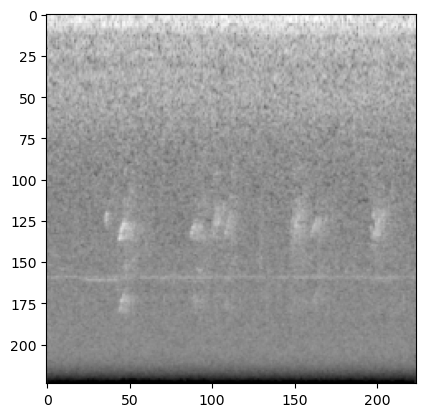

In [21]:
# Visualize a random spectrogram
row_index_sample = np.random.randint(0, len(sounds_train))
t = row_to_tensor(sounds_train.loc[row_index_sample, 'row_id'])
plt.imshow(t.squeeze().numpy(), cmap='gray')
plt.show()

In [22]:
sounds_train.head()

,row_id,site,audio_id,seconds,birds,filepath,has_call
31,7019_COR_160,COR,7019,160,nocall,../data/train_soundscapes_2021/7019_COR.ogg,0
1604,14473_SSW_225,SSW,14473,225,nocall,../data/train_soundscapes_2021/14473_SSW.ogg,0
302,11254_COR_315,COR,11254,315,nocall,../data/train_soundscapes_2021/11254_COR.ogg,0
1205,2782_SSW_30,SSW,2782,30,bkcchi reevir1,../data/train_soundscapes_2021/2782_SSW.ogg,1
1448,10534_SSW_45,SSW,10534,45,nocall,../data/train_soundscapes_2021/10534_SSW.ogg,0


# 3. Set up torch dataset

In [23]:
# Note: filepaths and labels should be ordinary lists
class BirdDataset2021(Dataset):
    def __init__(self, row_ids, labels):
        super().__init__()
        self.row_ids = row_ids
        self.labels = labels

    def __len__(self):
        return len(self.row_ids)

    def __getitem__(self, index):
        processed_clip = row_to_tensor(self.row_ids[index])
        return processed_clip, self.labels[index]

# 4. Defining neural network architecture 

In [24]:
class BirdCallIdentifier(nn.Module):
    ''' Pared down architecture from https://github.com/musikalkemist/pytorchforaudio/blob/main/10%20Predictions%20with%20sound%20classifier/cnn.py'''
    def __init__(self, num_classes):
        super(BirdCallIdentifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=2,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.dropout = nn.Dropout(p=0.1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(25088, num_classes)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

# 6. Training

In [25]:
# Set device we'll train on
device = None
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device}")

Using cpu


In [26]:
# Set model name if not set.
# Defaults to a timestamp, YYYY-MM-DD_HH_MM_SS
if MODEL_NAME == None:
    MODEL_NAME = 'birdcall_detection_'+str(pd.Timestamp.now()).replace(" ", "_").replace(":", "-").split(".")[0]

# Create a saving directory if needed
if SAVE_AFTER_TRAINING or SAVE_CHECKPOINTS or REPORT_TRAINING_LOSS_PER_EPOCH or REPORT_VALIDATION_LOSS_PER_EPOCH:
    output_dir = Path(f'{CHECKPOINT_DIR}{MODEL_NAME}')
    output_dir.mkdir(parents=True, exist_ok=True)

In [27]:
# Instantiate our training dataset
train_dataset = BirdDataset2021(row_ids = sounds_train['row_id'].to_list(), labels = sounds_train['has_call'].to_list())
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [28]:
# Instantiate our validation dataset
validation_dataset =  BirdDataset2021(row_ids = sounds_test['row_id'].to_list(), labels = sounds_test['has_call'].to_list())
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

In [29]:
# Instantiate our model
model = BirdCallIdentifier(2).to(device)

In [30]:
# Set our loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [31]:
# Training loop
print(f"Training on {len(train_dataset)} samples with {BATCH_SIZE} samples per batch.")
if REPORT_VALIDATION_LOSS_PER_EPOCH == True:
    print(f"Validating on {len(validation_dataset)} samples at the end of each epoch.")

training_losses = [None]*NUM_EPOCHS
validation_losses = [None]*NUM_EPOCHS

torch.enable_grad() # Turn on the gradient

for epoch_num, epoch in enumerate(tqdm(range(NUM_EPOCHS))):

    running_loss = 0.0
    
    for i, data in enumerate(tqdm(train_dataloader, leave = False)):
        
        # Get batch of inputs and true labels, push to device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass on batch of inputs
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Update weights
        optimizer.step()

        # Update loss
        running_loss += loss.item()

    # Save checkpoint
    if SAVE_CHECKPOINTS == True:
        torch.save(model.state_dict(), f"{CHECKPOINT_DIR}{MODEL_NAME}/checkpoint_{epoch_num+1}.pt")

    # Compute training loss
    if REPORT_TRAINING_LOSS_PER_EPOCH == True:    
        training_losses[epoch_num] = running_loss/len(train_dataloader)
        
    # Compute validation loss
    if REPORT_VALIDATION_LOSS_PER_EPOCH == True:
        validation_loss = 0.0
        model.eval()
        for validation_data in validation_dataloader:
            inputs, labels = validation_data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            validation_loss += criterion(outputs, labels).item()
        validation_losses[epoch_num] = validation_loss/len(validation_dataloader)
        model.train()

print('Finished Training')

Training on 1920 samples with 32 samples per batch.
Validating on 480 samples at the end of each epoch.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

# 6. Save the model and report results

In [193]:
if SAVE_AFTER_TRAINING == True:
    torch.save(model.state_dict(), f"{CHECKPOINT_DIR}{MODEL_NAME}/final.pt")

In [194]:
losses = pd.DataFrame({"training_losses":training_losses, "validation_losses":validation_losses})
cols = []
if REPORT_TRAINING_LOSS_PER_EPOCH == True:
    cols += ["training_losses"]
if REPORT_VALIDATION_LOSS_PER_EPOCH == True:
    cols += ["validation_losses"]
if len(cols) > 0:
    losses[cols].to_csv(f"{CHECKPOINT_DIR}{MODEL_NAME}/losses.csv")
    print(losses)

    training_losses  validation_losses
0         11.707063           0.682369
1          0.687973           0.703528
2          0.660276           0.616452
3          0.605941           0.498080
4          0.559103           0.474193
5          0.502334           0.456886
6          0.428982           0.703355
7          0.414212           0.546228
8          0.359036           0.450571
9          0.351114           0.591142
10         0.277455           0.463333
11         0.232559           0.691232
12         0.242519           0.761311
13         0.189807           0.501313
14         0.182417           0.427239
15         0.120202           0.419062
16         0.134286           0.409277
17         0.084987           0.514503
18         0.095000           0.555285
19         0.120446           0.891212
